# Model Emotion Recognition

Implementasi Convolutional Neural Network (CNN) menggunakan PyTorch dan ResNet (Residual Network) yang telah dilatih sebelumnya untuk melakukan pengenalan emosi.

## CNN Pytorch with PreTrained ResNet

**CNN** adalah jenis Deep Learning model yang sangat efektif untuk tugas yang berhubungan dengan pengolahan gambar. **ResNet** adalah jenis network yang ditambahkan khusus untuk memudahkan proses training network.

In [ ]:
%pip install torch torchvision numpy matplotlib torchsummary

## Modifying Pre-trained ResNet Model for Custom Emotion Recognition

- https://pytorch.org/hub/pytorch_vision_resnet/
- https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [ ]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)

from torchsummary import summary
summary(model, (3, 32, 32), device='cpu')

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

print(model.fc)
from torchsummary import summary
summary(model, (3, 32, 32), device='cpu')

## Preparing Dataset and DataLoader

In [59]:
from torchvision import datasets, transforms

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(data_transforms['train'])
print(data_transforms['val'])

Compose(
    Grayscale(num_output_channels=3)
    RandomHorizontalFlip(p=0.5)
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition

In [60]:
from torch.utils.data import DataLoader

trainset = datasets.ImageFolder(root='dataset/kaggle', transform=data_transforms['train'])
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

valset = datasets.ImageFolder(root='dataset/kaggle', transform=data_transforms['val'])
valloader = DataLoader(valset, batch_size=32, shuffle=True)

trainloader, valloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb4312b6970>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb4300f21f0>)

In [61]:
dataloaders = {'train': trainloader, 'val': valloader}
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fb4312b6970>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fb4300f21f0>}


## Visualization of Label Distribution

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def label_distribution(trainset):
    labels = np.array(trainset.targets)
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10,7))
    bars = plt.bar(trainset.classes, counts)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')

    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

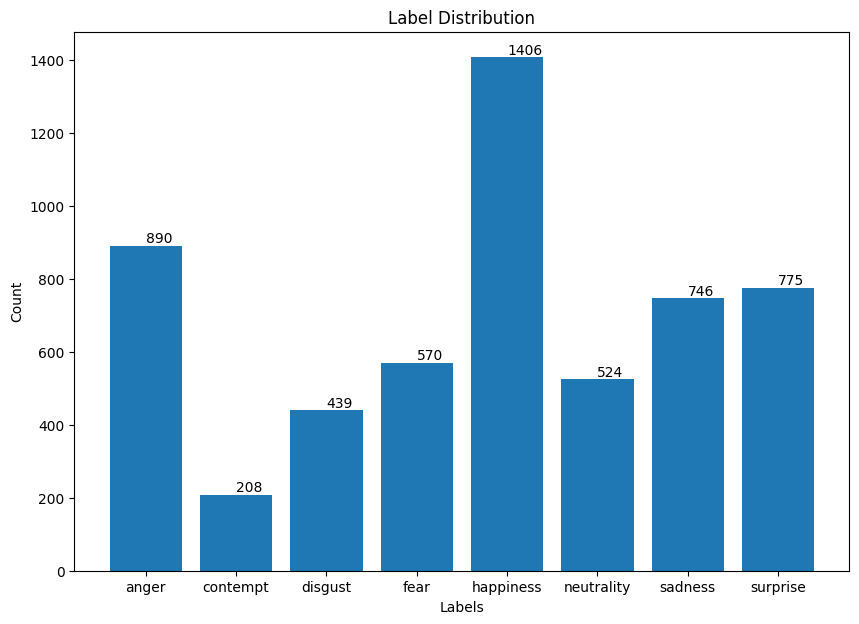

In [63]:
label_distribution(trainset)

## Training and Validation phase

In [ ]:
import torch
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)


print(device)
print(model.parameters())
print(criterion)
print(optimizer)

In [65]:
from torch.optim import lr_scheduler

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(exp_lr_scheduler)

In [34]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    return running_loss, running_corrects
    

In [66]:
running_loss, running_corrects = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
print(running_loss, running_corrects)

num_samples = len(dataloaders['train'].dataset)
average_loss = running_loss / num_samples
accuracy = running_corrects.double() / num_samples
print(f'Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

10425.559143781662 tensor(1772, device='cuda:0')
Loss: 1.8758, Accuracy: 0.3188


In [69]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    return running_loss, running_corrects

In [ ]:
running_loss, running_corrects = validate_one_epoch(model, dataloaders['val'], criterion, device)
print(running_loss, running_corrects)

num_samples = len(dataloaders['val'].dataset)
average_loss = running_loss / num_samples
accuracy = running_corrects.double() / num_samples
print(f'Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

In [70]:
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists for plot
    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training phase
        running_loss, running_corrects = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)

        scheduler.step()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_acc)

        # Validation phase
        running_loss, running_corrects = validate_one_epoch(model, dataloaders['val'], criterion, device)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))
        val_loss_values.append(epoch_loss)
        val_acc_values.append(epoch_acc)

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_values, train_acc_values, val_loss_values, val_acc_values, best_acc

In [71]:
model, train_loss_values, train_acc_values, val_loss_values, val_acc_values, best_acc = train_model(
    model, dataloaders, criterion, optimizer, exp_lr_scheduler, device, num_epochs=25
)

Epoch 0/24
----------


train Loss: 1.4829 Acc: 0.4604
val Loss: 1.5368 Acc: 0.4725

Epoch 1/24
----------
train Loss: 1.3973 Acc: 0.4872
val Loss: 1.2956 Acc: 0.5178

Epoch 2/24
----------
train Loss: 1.3484 Acc: 0.5142
val Loss: 1.2279 Acc: 0.5718

Epoch 3/24
----------
train Loss: 1.2760 Acc: 0.5493
val Loss: 1.1742 Acc: 0.5788

Epoch 4/24
----------
train Loss: 1.2200 Acc: 0.5624
val Loss: 1.1041 Acc: 0.6112

Epoch 5/24
----------
train Loss: 1.1824 Acc: 0.5772
val Loss: 1.1287 Acc: 0.5806

Epoch 6/24
----------
train Loss: 0.9879 Acc: 0.6484
val Loss: 0.8401 Acc: 0.7082

Epoch 7/24
----------
train Loss: 0.8912 Acc: 0.6812
val Loss: 0.7677 Acc: 0.7397

Epoch 8/24
----------
train Loss: 0.8155 Acc: 0.7098
val Loss: 0.7056 Acc: 0.7603

Epoch 9/24
----------
train Loss: 0.7654 Acc: 0.7271
val Loss: 0.6405 Acc: 0.7843

Epoch 10/24
----------
train Loss: 0.7274 Acc: 0.7483
val Loss: 0.5955 Acc: 0.8015

Epoch 11/24
----------
train Loss: 0.6758 Acc: 0.7659
val Loss: 0.5498 Acc: 0.8122

Epoch 12/24
----------
t

## Visualization

In [9]:
import matplotlib.pyplot as plt

def plot_acc_loss(train_loss_values, val_loss_values, train_acc_values, val_acc_values):
    # moving the tensor to cpu and converting them to numpy array for plotting
    train_acc_values_cpu = [acc.cpu().detach().numpy() for acc in train_acc_values]
    val_acc_values_cpu = [acc.cpu().detach().numpy() for acc in val_acc_values]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plotting the loss values
    ax1.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', label='Training Loss')
    ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o', label='Validation Loss')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.set_title('Epoch vs Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True)

    # Plotting the accuracy values
    ax2.plot(range(1, len(train_acc_values_cpu) + 1), train_acc_values_cpu, marker='o', label='Training Accuracy')
    ax2.plot(range(1, len(val_acc_values_cpu) + 1), val_acc_values_cpu, marker='o', label='Validation Accuracy')
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.set_title('Epoch vs Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

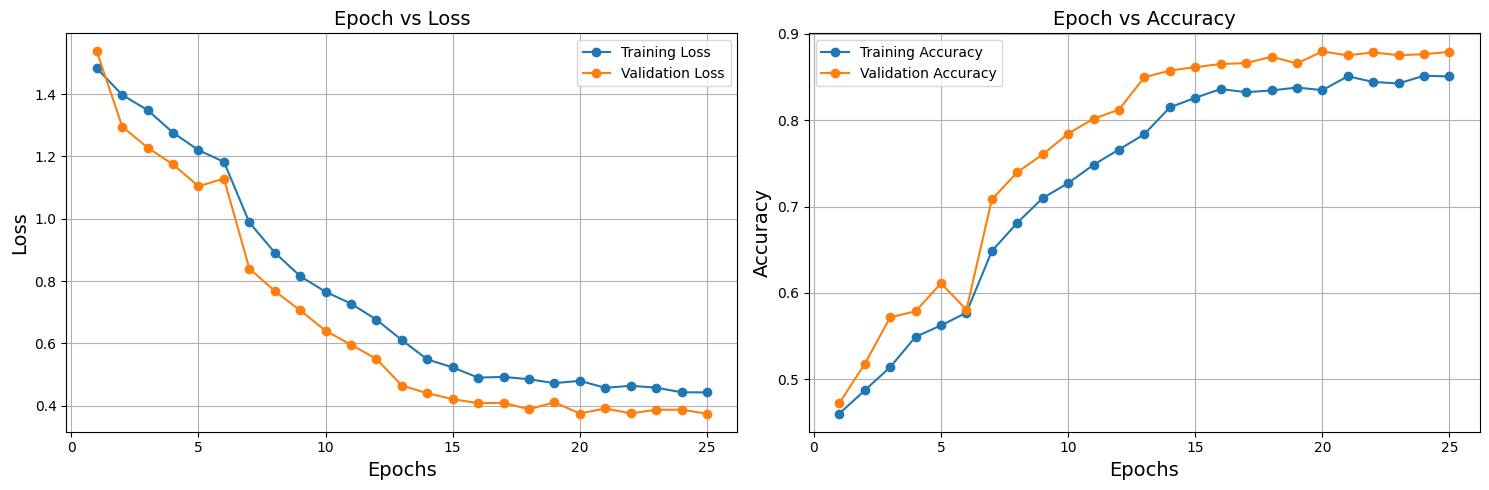

In [72]:
plot_acc_loss(train_loss_values, val_loss_values, train_acc_values, val_acc_values)

## Save Model

In [73]:
torch.save(model, 'model/pytorch/emotion_tutorial.pth')

## Use the model

In [39]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import torch.nn.functional as F

def predict_image(use_model, image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(use_model)
    model = model.to(device)

    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.show()

    # Predict emotion
    image_transformed = transform(image).unsqueeze(0)
    image_transformed = image_transformed.to(device)
    with torch.no_grad():
        output = model(image_transformed)
        probabilities = F.softmax(output, dim=1)
        
    emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']
    emotion_probability_pair = [(emotion, probability.item()*100) for emotion, probability in zip(emotion_labels, probabilities[0])]
    emotion_probability_pair.sort(key=lambda x: x[1], reverse=True)

    # Print each emotion with its corresponding probability
    for emotion, probability in emotion_probability_pair:
        print(f"{emotion}: {probability}%")


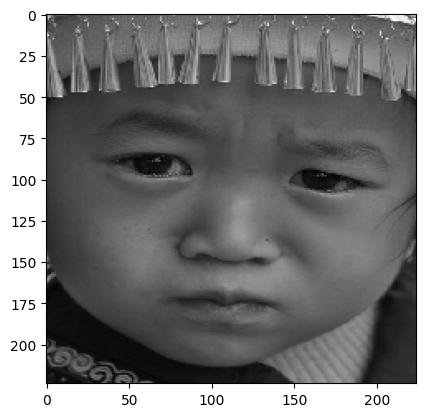

sadness: 60.630255937576294%
disgust: 36.77390217781067%
anger: 1.4469222165644169%
neutrality: 0.7474042940884829%
contempt: 0.32409303821623325%
happiness: 0.07069141138345003%
fear: 0.006320067768683657%
surprise: 0.00041043276723939925%


In [77]:
# Test the model:
model_path = 'model/master/emotion_model_pytorch.pth'
predict_image(model_path, 'dataset/kaggle/sadness/26787692723_727b1de390_b_face.png')
# predict_image(model_path, 'dataset/kaggle/anger/2Q__ (2)_face.png')
# predict_image(model_path, 'dataset/sample/test/surprise/PublicTest_88902041.jpg')
# predict_image(model_path, 'dataset/web/happy/image-1.jpg')